In [1]:
#import config

import torch
import torch.nn as nn
import torch.optim as optim
import wandb

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/kaggle/input/source')
#import file

import numpy as np
import os
import pandas as pd
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm

import math

In [2]:
#!pip install --upgrade -q wandb

In [3]:
#wandb.login()

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 

wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb_default_config = {
    'BATCH_SIZE': 8,
    'NUM_EPOCHS': 10,
    'LEARNING_RATE': 0.05657808132757078,
    'WEIGHT_DECAY': 1e-4}

In [6]:
from pprint import pprint 
sweep_config = {
    'name': 'YOLO',
    'method': 'bayes',
    'metric': {
        'name': 'val_loss', 
        'goal': 'minimize' 
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 3
    },
    'parameters': {
        'BATCH_SIZE': {
            'values': [8, 16, 32]
        },
        'NUM_EPOCHS': {
            'values': [5, 10, 15]
        },
        'LEARNING_RATE': {
            'min': 0.0001,
            'max': 0.1
        },
        'WEIGHT_DECAY': {
            'min': 0.0001,
            'max': 0.1
        }, 
    }
}

pprint(sweep_config)

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="YOLO",
    # track hyperparameters and run metadata
    config=wandb_default_config,
    entity='matovic_horvat'
)

sweep_id = wandb.sweep(sweep_config, project="YOLO", entity='matovic_horvat')

wandb: Currently logged in as: xmatovice (matovic_horvat). Use `wandb login --relogin` to force relogin


{'early_terminate': {'min_iter': 3, 'type': 'hyperband'},
 'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'name': 'YOLO',
 'parameters': {'BATCH_SIZE': {'values': [8, 16, 32]},
                'LEARNING_RATE': {'max': 0.1, 'min': 0.0001},
                'NUM_EPOCHS': {'values': [5, 10, 15]},
                'WEIGHT_DECAY': {'max': 0.1, 'min': 0.0001}}}


Create sweep with ID: 82iol6xo
Sweep URL: https://wandb.ai/matovic_horvat/YOLO/sweeps/82iol6xo


In [ ]:
DATASET = '../../zadanie2' #'../imgs'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4
BATCH_SIZE = 8
IMAGE_SIZE = 416
NUM_CLASSES = 4 #classes to clasificate (vehicle,pedestrian,...)
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 12
CONF_THRESHOLD = 0.6
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
S_CONFIG = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
PIN_MEMORY = True
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_FILE = "checkpoint.pth.tar"
IMG_DIR = DATASET + "/images/"
LABEL_DIR = "../label/"
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  #between [0, 1]


scale = 1.1
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[], check_each_transform=True),
)

CLASSES_LABELS = [
    "pedestrian",
    "car",
    "traffic light",
    "sign"
]

In [7]:
config1 = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],
    # until here is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [8]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + self.use_residual * x

        return x

In [10]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes): #anchors_per_scale
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes
        self.anchors_per_scale = 3 #anchors_per_scale

    def forward(self, x):
        return (
            self.pred(x)
                .reshape(x.shape[0], self.anchors_per_scale, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2)
        )

In [11]:
print(config1)

[(32, 3, 1), (64, 3, 2), ['B', 1], (128, 3, 2), ['B', 2], (256, 3, 2), ['B', 8], (512, 3, 2), ['B', 8], (1024, 3, 2), ['B', 4], (512, 1, 1), (1024, 3, 1), 'S', (256, 1, 1), 'U', (256, 1, 1), (512, 3, 1), 'S', (128, 1, 1), 'U', (128, 1, 1), (256, 3, 1), 'S']


In [12]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config1:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    in_channels = in_channels * 3

        return layers

In [13]:
def test():
    num_classes = 4#20
    img_size = 416
    model = YOLOv3(num_classes=num_classes)

    x = torch.randn((2, 3, img_size, img_size))
    out = model(x)
    assert out[0].shape == (2, 3, img_size//32, img_size//32, 5 + num_classes)
    assert out[1].shape == (2, 3, img_size//16, img_size//16, 5 + num_classes)
    assert out[2].shape == (2, 3, img_size//8, img_size//8, 5 + num_classes)

test()

# Loss

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [14]:
sys.path.insert(1, '/kaggle/input/source')

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0
        no_object_loss = self.bce((predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),)
        anchors = anchors.reshape(1, 3, 1, 1, 2) # reshape anchors to allow for broadcasting in multiplication below
        # convert outputs from model to bboxes
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        #width and height to the same format as predictions
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )
        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [15]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # na errory pri loadovani img

In [17]:
def check_bbox(bboxes):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
    #my added block 
    #bbox=list(bbox)
    for bbox in bboxes:
      print(bbox)
      for i in range(1):
        if (bbox[i]<0) :
              print(True)
        #  bbox[i]=0
        #elif (bbox[i]>1) :
        #  bbox[i]=1
        print((((bbox[3] + bbox[i]) / 2) / 416) < 0)
      #bbox=tuple(bbox)
   #end of block
   #rest of the code as it is

In [ ]:
def iou_width_height(boxes1, boxes2):
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]
        bboxes_after_nms.append(chosen_box)
    return bboxes_after_nms

def plot_image(image, boxes):
    cmap = plt.get_cmap("tab20b")
    class_labels = CLASSES_LABELS
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )
    plt.show()

In [18]:
class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=4,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        #3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    #print(x_cell, y_cell)
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction
        return image, tuple(targets)

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  0


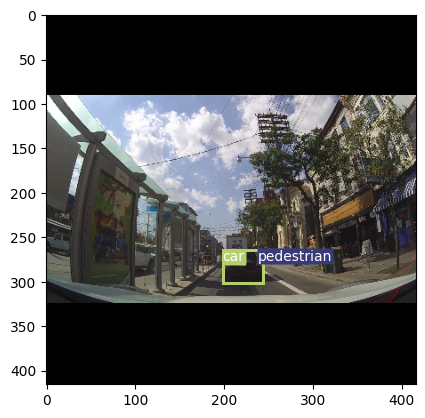

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  1


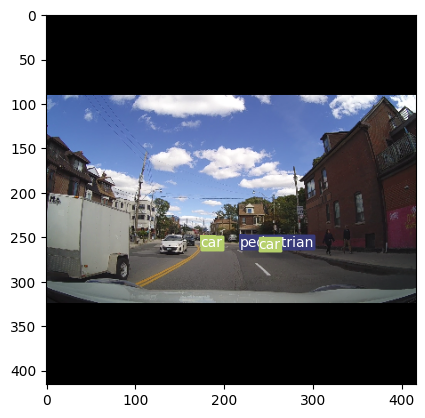

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  2


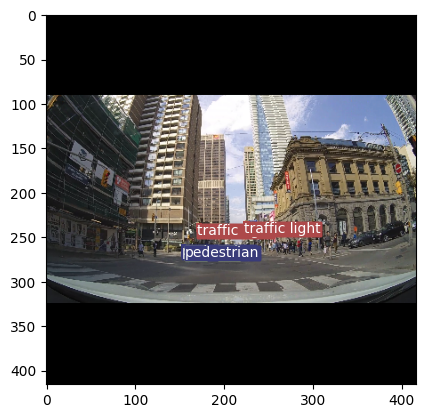

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  3


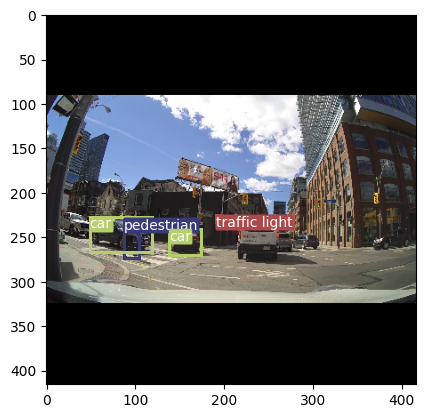

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  4


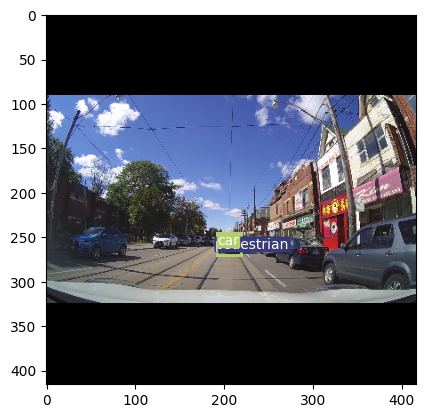

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  5


In [19]:
def test():
    anchors = ANCHORS

    transform = test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/train.csv',
        '/kaggle/input/images/',
        '/kaggle/input/labels/label/',
        S=S_CONFIG,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = S_CONFIG #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    counter = 0
    for x, y in loader:
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)

test()

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  0


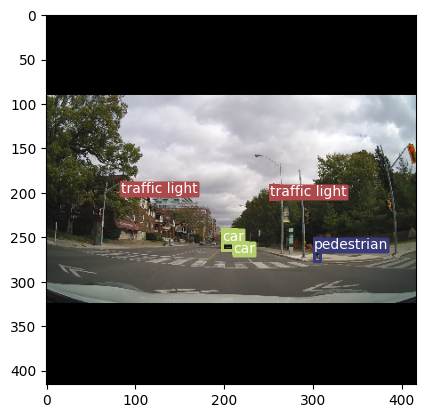

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  1


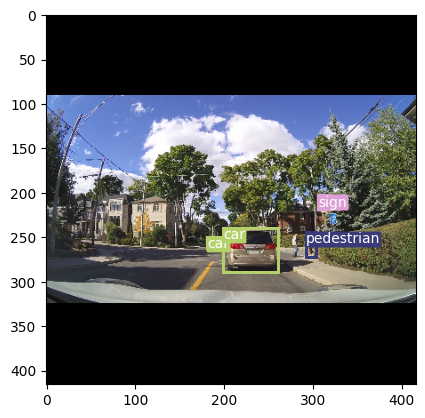

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  2


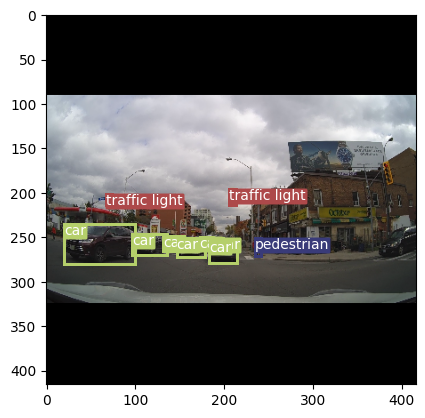

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  3


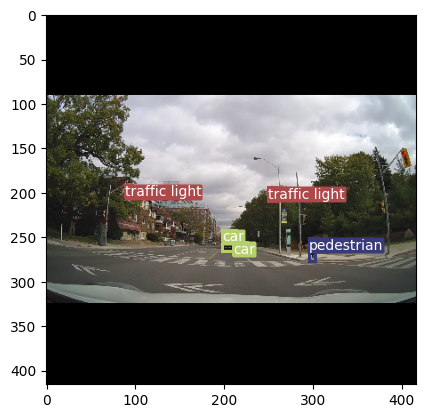

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  4


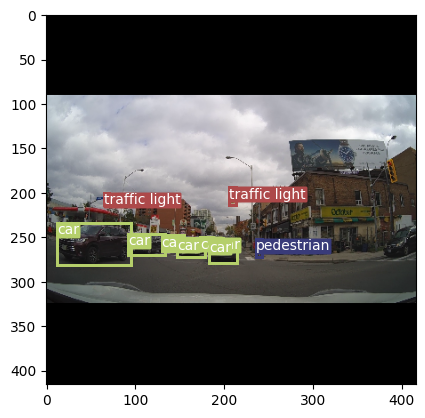

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  5


In [20]:
def test():
    anchors = ANCHORS

    transform = test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=S_CONFIG,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = S_CONFIG #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    counter = 0
    for x, y in loader:
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)

test()

# Training

In [21]:
import gc
#def report_gpu():
#print(torch.cuda.list_gpu_processes())
gc.collect()

7471

In [22]:
torch.cuda.empty_cache()

In [23]:
gc.collect()

0

In [24]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        elif math.isnan(validation_loss):
            return True
        return False

In [25]:
def accuracy_fn(y_true, y_pred):
    """
    Calculate equality of two tensors.
    :param y_true: real output
    :param y_pred: predictions
    :returns correctness
    """
    correct = torch.eq(y_true, y_pred).sum().item() 
    return correct

def check_class_accuracy(y, y_hat, threshold=0.6):
    #model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    #for idx, (x, y) in enumerate(loader):
    #    if idx == 100:
    #        break
    #    x = x.float()
    #    x = x.to(DEVICE)
        #with torch.no_grad():
            #print(x.shape)
        #    out = model(x)
    for i in range(3):
        y[i] = y[i].to(DEVICE)
        obj = y[i][..., 0] == 1 # in paper this is Iobj_i
        noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

        correct_class += torch.sum(
            torch.argmax(y_hat[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
        )
        tot_class_preds += torch.sum(obj)

        obj_preds = torch.sigmoid(y_hat[i][..., 0]) > threshold
        correct_obj += accuracy_fn(y[i][..., 0][obj], obj_preds[obj])
        tot_obj += torch.sum(obj)
        correct_noobj += accuracy_fn(y[i][..., 0][noobj], obj_preds[noobj])
        tot_noobj += torch.sum(noobj)

    return correct_class, tot_class_preds, correct_noobj, tot_noobj, correct_obj, tot_obj

In [26]:
def test_fn(loader, model, optimizer, scaled_anchors):
    """
    Evaulation
    """
    losses = []
    batches_counter = 0
    counter = 0

    # init epoch train counters
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    
    # disable gradient calculation
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader): #enumerate(loop):
            x = x.float()
            x = x.to(DEVICE)
            y0, y1, y2 = (
                y[0].to(DEVICE),
                y[1].to(DEVICE),
                y[2].to(DEVICE),
            )

            y_hat = model(x)

            correct_class_, tot_class_preds_, correct_noobj_, tot_noobj_, \
                correct_obj_, tot_obj_ = check_class_accuracy(y, y_hat, CONF_THRESHOLD)
            
            correct_class += correct_class_
            tot_class_preds += tot_class_preds_
            correct_noobj += correct_noobj_
            tot_noobj += tot_noobj_
            correct_obj += correct_obj_
            tot_obj += tot_obj_
            
            batches_counter+=1
            
            if counter < 19:
                counter += 1
                if batches_counter % 16 == 0:
                    boxes = []
                    for i in range(y[0].shape[1]):
                        anchor = scaled_anchors[i]
                        print("Shape of anchor: ",anchor.shape)
                        print("Loader y: ",y[i].shape)
                        boxes += cells_to_bboxes(
                            y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
                        )[0]
                    boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
                    plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


    class_acc = (correct_class/(tot_class_preds+1e-16))*100
    no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
    obj_acc = (correct_obj/(tot_obj+1e-16))*100
    
    pred_boxes, true_boxes = get_evaluation_bboxes(
        loader,
        model,
        iou_threshold=NMS_IOU_THRESH,
        anchors=ANCHORS,
        threshold=CONF_THRESHOLD,
    )
    mapval = mean_average_precision(
        pred_boxes,
        true_boxes,
        iou_threshold=MAP_IOU_THRESH,
        box_format="midpoint", #midpoint originally
        num_classes=NUM_CLASSES,
    )
    
    return class_acc, no_obj_acc, obj_acc, mapval

In [27]:
def val_fn(loader, model, optimizer, loss_fn, scaled_anchors):
    """
    Validation
    """
    losses = []
    batches_counter = 0

    # init epoch train counters
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    
    # disable gradient calculation
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader): #enumerate(loop):
            x = x.float()
            x = x.to(DEVICE)
            y0, y1, y2 = (
                y[0].to(DEVICE),
                y[1].to(DEVICE),
                y[2].to(DEVICE),
            )

            y_hat = model(x)
            loss = (
                loss_fn(y_hat[0], y0, scaled_anchors[0])
                + loss_fn(y_hat[1], y1, scaled_anchors[1])
                + loss_fn(y_hat[2], y2, scaled_anchors[2])
            )

            losses.append(loss.item())

            correct_class_, tot_class_preds_, correct_noobj_, tot_noobj_, \
                correct_obj_, tot_obj_ = check_class_accuracy(y, y_hat, CONF_THRESHOLD)
            
            correct_class += correct_class_
            tot_class_preds += tot_class_preds_
            correct_noobj += correct_noobj_
            tot_noobj += tot_noobj_
            correct_obj += correct_obj_
            tot_obj += tot_obj_
            
            batches_counter+=1

    mean_loss = sum(losses) / len(losses)
    class_acc = (correct_class/(tot_class_preds+1e-16))*100
    no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
    obj_acc = (correct_obj/(tot_obj+1e-16))*100
    
    return mean_loss, class_acc, no_obj_acc, obj_acc

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    average_precisions = [] # list storing all AP for respective classes
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        #skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))
    return sum(average_precisions) / len(average_precisions)


def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


def get_evaluation_bboxes(loader,model,iou_threshold,anchors,threshold,box_format="midpoint",device=DEVICE):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)
        with torch.no_grad():
            predictions = model(x)
        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1
    model.train()
    return all_pred_boxes, all_true_boxes


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [28]:
torch.backends.cudnn.benchmark = True

def train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors):
    """
    Training
    """
    losses = []
    batches_counter = 0

    # init epoch train counters
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    
    for batch_idx, (x, y) in enumerate(train_loader): #enumerate(loop):

        x = x.float()
        x = x.to(DEVICE)
        y0, y1, y2 = (
            y[0].to(DEVICE),
            y[1].to(DEVICE),
            y[2].to(DEVICE),
        )
        
        # clear the gradients
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            y_hat = model(x)
            loss = (
                loss_fn(y_hat[0], y0, scaled_anchors[0])
                + loss_fn(y_hat[1], y1, scaled_anchors[1])
                + loss_fn(y_hat[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        correct_class_, tot_class_preds_, correct_noobj_, tot_noobj_, \
            correct_obj_, tot_obj_ = check_class_accuracy(y, y_hat, CONF_THRESHOLD)
        
        correct_class += correct_class_
        tot_class_preds += tot_class_preds_
        correct_noobj += correct_noobj_
        tot_noobj += tot_noobj_
        correct_obj += correct_obj_
        tot_obj += tot_obj_
        
        # class_acc, no_obj_acc, obj_acc
        #loop.set_postfix(loss=mean_loss)
        #print('loss', mean_loss)
        #print(batches_counter)
        batches_counter+=1
    
    mean_loss = sum(losses) / len(losses)
    class_acc = (correct_class/(tot_class_preds+1e-16))*100
    no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
    obj_acc = (correct_obj/(tot_obj+1e-16))*100
    
    return mean_loss, class_acc, no_obj_acc, obj_acc


def sweep_fn():
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="YOLO",
        # track hyperparameters and run metadata
        config=wandb_default_config,
        entity='matovic_horvat'
    )

    wandb_config = wandb.config
    
    model = YOLOv3(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=wandb_config.LEARNING_RATE, weight_decay=wandb_config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    train_dataset = YOLODataset(
        '/kaggle/input/mapping/train.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=wandb_config.BATCH_SIZE,
        #num_workers=0,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    val_dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',#'../test.csv',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=ANCHORS,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=wandb_config.BATCH_SIZE,
        #num_workers=0,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    
    test_dataset = YOLODataset(
        '/kaggle/input/mapping/test.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        anchors=ANCHORS,
        transform=test_transforms,
    )

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=wandb_config.BATCH_SIZE,
                             pin_memory=PIN_MEMORY,
                             shuffle=False,
                             drop_last=False,)

    scaled_anchors = (
        torch.tensor(ANCHORS)
        * torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(DEVICE)
    epoch_counter = 0
    
    # init train lists for statistics
    loss_train, class_acc_train, no_obj_acc_train, \
        obj_acc_train = list(), list(), list(), list()

    # init validation lists for statistics
    loss_val, class_acc_val, no_obj_acc_val, \
        obj_acc_val = list(), list(), list(), list()
    
    # early stopper
    early_stopper = EarlyStopper(patience=3, min_delta=1)
    for epoch in range(wandb_config.NUM_EPOCHS):
        # init epoch train counters
        epoch_train_acc, epoch_train_total, \
            epoch_train_true, epoch_train_loss = 0, 0, 0, 0

        print(f"Currently epoch {epoch}")
        
        mean_loss, class_acc, no_obj_acc, obj_acc = \
            train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors)
        
        print(f"Train loss: {mean_loss:2f}")
        print(f"Train Class accuracy is: {class_acc:2f}%")
        print(f"Train No obj accuracy is: {no_obj_acc:2f}%")
        print(f"Train Obj accuracy is: {obj_acc:2f}%")
        
        loss_train.append(mean_loss)
        class_acc_train.append(class_acc)
        no_obj_acc_train.append(no_obj_acc)
        obj_acc_train.append(obj_acc)
        
        if SAVE_MODEL:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        # validation
        mean_loss, class_acc, no_obj_acc, obj_acc = \
            val_fn(val_loader, model, optimizer, loss_fn, scaled_anchors)
        
        print(f"Val loss: {mean_loss:2f}")
        print(f"Val Class accuracy is: {class_acc:2f}%")
        print(f"Val No obj accuracy is: {no_obj_acc:2f}%")
        print(f"Val Obj accuracy is: {obj_acc:2f}%")
        
        loss_val.append(mean_loss)
        class_acc_val.append(class_acc)
        no_obj_acc_val.append(no_obj_acc)
        obj_acc_val.append(obj_acc)
        
        # log metrics to WandB
        wandb.log({"train loss": loss_train[-1], 
                  "val_loss": loss_val[-1],
                  "train class accuracy": class_acc_train[-1],
                  "validation class accuracy": class_acc_val[-1],
                  "train no obj accuracy": no_obj_acc_train[-1],
                  "validation no obj accuracy": no_obj_acc_val[-1],
                  "train obj accuracy": obj_acc_train[-1],
                  "validation obj accuracy": obj_acc_val[-1]
                  })

        
        epoch_counter+=1
        
        # early stopping
        if early_stopper.early_stop(mean_loss):    
            print(f'Early stopped at {epoch_counter - 1}')         
            break

In [29]:
#wandb.agent(sweep_id, function=sweep_fn, count=5, project='YOLO', entity='matovic_horvat')

In [30]:
wandb.finish()

wandb: Sorting runs by +summary_metrics.val_loss


dp6aacyk
{'BATCH_SIZE': 8,
 'LEARNING_RATE': 0.011452697406891536,
 'NUM_EPOCHS': 10,
 'WEIGHT_DECAY': 0.05543324440170564}


Currently epoch 0
Train loss: 18.900505
Train Class accuracy is: 57.733707%
Train No obj accuracy is: 99.946190%
Train Obj accuracy is: 0.058500%
=> Saving checkpoint
Val loss: 19.240331
Val Class accuracy is: 52.978928%
Val No obj accuracy is: 99.999992%
Val Obj accuracy is: 0.000000%
Currently epoch 1
Train loss: 10.527062
Train Class accuracy is: 76.529778%
Train No obj accuracy is: 99.997345%
Train Obj accuracy is: 0.289575%
=> Saving checkpoint
Val loss: 15.267784
Val Class accuracy is: 59.738934%
Val No obj accuracy is: 99.998024%
Val Obj accuracy is: 0.000000%
Currently epoch 2
Train loss: 7.247134
Train Class accuracy is: 88.396515%
Train No obj accuracy is: 99.975929%
Train Obj accuracy is: 2.731953%
=> Saving checkpoint
Val loss: 16.661410
Val Class accuracy is: 64.982132%
Val No obj accuracy is: 99.992653%
Val Obj accuracy is: 0.422956%
Currently epoch 3
Train loss: 6.437527
Train Class accuracy is: 91.406342%
Train No obj accuracy is: 99.954636%
Train Obj accuracy is: 4.124

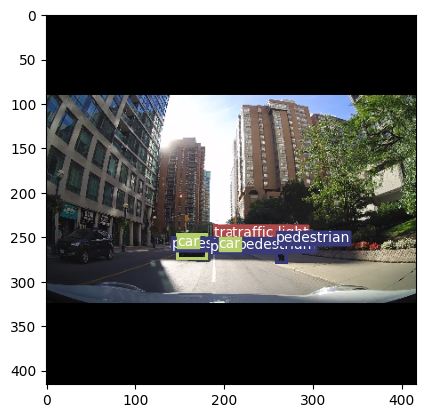

100%|██████████| 175/175 [02:43<00:00,  1.07it/s]


Test Class accuracy is: 59.085529%
Test No obj accuracy is: 99.913361%
Test Obj accuracy is: 1.585717%
MAP: 0.008736166171729565


In [32]:
def best_run():
    api = wandb.Api()
    sweep = api.sweep("matovic_horvat/YOLO/g2vy2q40")

    best_run = sweep.best_run()
    print(best_run.id)
    pprint(best_run.config)
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="YOLO",
        # track hyperparameters and run metadata
        config=best_run.config,
        entity='matovic_horvat'
    )
    wandb_config = wandb.config
    
    model = YOLOv3(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=wandb_config.LEARNING_RATE, weight_decay=wandb_config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    #scaler = torch.cuda.amp.GradScaler()

    # train_loader, test_loader, train_eval_loader = get_loaders(
    #     train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/train.csv"
    # )

    train_dataset = YOLODataset(
        '/kaggle/input/mapping/train.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=wandb_config.BATCH_SIZE,
        #num_workers=0,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    val_dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',#'../test.csv',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=ANCHORS,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=wandb_config.BATCH_SIZE,
        #num_workers=0,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    
    test_dataset = YOLODataset(
        '/kaggle/input/mapping/test.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        anchors=ANCHORS,
        transform=test_transforms,
    )

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=wandb_config.BATCH_SIZE,
                             pin_memory=PIN_MEMORY,
                             shuffle=False,
                             drop_last=False,)

    # if config.LOAD_MODEL:
    #     load_checkpoint(
    #         config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    #     )

    scaled_anchors = (
        torch.tensor(ANCHORS)
        * torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(DEVICE)
    epoch_counter = 0
    
    # init train lists for statistics
    loss_train, class_acc_train, no_obj_acc_train, \
        obj_acc_train = list(), list(), list(), list()

    # init validation lists for statistics
    loss_val, class_acc_val, no_obj_acc_val, \
        obj_acc_val = list(), list(), list(), list()
    
    # early stopper
    early_stopper = EarlyStopper(patience=3, min_delta=1)
    for epoch in range(wandb_config.NUM_EPOCHS):
        # init epoch train counters
        epoch_train_acc, epoch_train_total, \
            epoch_train_true, epoch_train_loss = 0, 0, 0, 0
        
        #print(epoch_counter)
        print(f"Currently epoch {epoch}")
        #plot_couple_examples(model, train_loader, 0.6, 0.5, scaled_anchors)
        #train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
        
        mean_loss, class_acc, no_obj_acc, obj_acc = \
            train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors)
        
        print(f"Train loss: {mean_loss:2f}")
        print(f"Train Class accuracy is: {class_acc:2f}%")
        print(f"Train No obj accuracy is: {no_obj_acc:2f}%")
        print(f"Train Obj accuracy is: {obj_acc:2f}%")
        
        loss_train.append(mean_loss)
        class_acc_train.append(class_acc)
        no_obj_acc_train.append(no_obj_acc)
        obj_acc_train.append(obj_acc)
        
        if SAVE_MODEL:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        # validation
        mean_loss, class_acc, no_obj_acc, obj_acc = \
            val_fn(val_loader, model, optimizer, loss_fn, scaled_anchors)
        
        print(f"Val loss: {mean_loss:2f}")
        print(f"Val Class accuracy is: {class_acc:2f}%")
        print(f"Val No obj accuracy is: {no_obj_acc:2f}%")
        print(f"Val Obj accuracy is: {obj_acc:2f}%")
        
        loss_val.append(mean_loss)
        class_acc_val.append(class_acc)
        no_obj_acc_val.append(no_obj_acc)
        obj_acc_val.append(obj_acc)
        
        epoch_counter+=1
        
        # early stopping
        if early_stopper.early_stop(mean_loss):    
            print(f'Early stopped at {epoch_counter - 1}')         
            break
        
    class_acc, no_obj_acc, obj_acc, mapval = \
            test_fn(test_loader, model, optimizer, scaled_anchors)
    
    print(f"Test Class accuracy is: {class_acc:2f}%")
    print(f"Test No obj accuracy is: {no_obj_acc:2f}%")
    print(f"Test Obj accuracy is: {obj_acc:2f}%")
    print(f"MAP: {mapval.item()}")

best_run()

In [ ]:
#os.remove("/kaggle/input/source/utils.py")
